## Wikidata Knowledge Graph Extraction
Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs (KGs) as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:
- How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
- How to find surrounding entities and descriptions for an entity
- Create a KG for Movielens

In [1]:
# Set logging error
import logging
logger = logging.getLogger()
logger.setLevel(logging.ERROR)
for handler in logger.handlers:
    handler.setLevel(level)

import sys
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from recommenders.datasets import movielens
from recommenders.datasets.wikidata import (search_wikidata, 
                                         find_wikidata_id, 
                                         query_entity_links, 
                                         read_linked_entities,
                                         query_entity_description)
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")

/home/u/anaconda/envs/recommenders/lib/python3.9/site-packages/pyspark/pandas/__init__.py:47: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


System version: 3.9.16 (main, May 15 2023, 23:46:34) 
[GCC 11.2.0]


In [2]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"
MOVIELENS_SAMPLE = True
MOVIELENS_SAMPLE_SIZE = 50

## 1. Create a KG from linked entities in Wikidata

In [3]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]

In [4]:
%%time

# the following code has been wrapped in a helper function called search_wikidata()
# it is provided here to show the details of which calls are being made to wikipedia APIs

# capture results as a list of dicts to transform to DataFrame (this is faster than appending to DataFrames)
results_list = []
for idx, name in enumerate(names):
    # first get the wikipedia entity_id for each name
    entity_id = find_wikidata_id(name)
    if entity_id == "entityNotFound":
        continue

    # next we query wikipedia to get entity links
    json_links = query_entity_links(entity_id)

    # the following function extracts entities from the links
    related_links = read_linked_entities(json_links)

    # now we can construct an connection in our graph between two entities
    for related_entity, related_name in related_links:
        result = dict(
            name=name,
            original_entity=entity_id,
            linked_entities=related_entity,
            name_linked_entities=related_name,
        )
        results_list.append(result)

results_list = pd.DataFrame(results_list)
results_list.head()

CPU times: user 298 ms, sys: 32.8 ms, total: 330 ms
Wall time: 10.6 s


,name,original_entity,linked_entities,name_linked_entities
0,The Godfather,Q47703,Q377616,New Hollywood
1,The Godfather,Q47703,Q130232,drama film
2,The Godfather,Q47703,Q52207399,film based on a novel
3,The Godfather,Q47703,Q7444356,gangster film
4,The Godfather,Q47703,Q959790,crime film


### Visualize KG using network

In [5]:
G = nx.from_pandas_edgelist(results_list, "original_entity", "linked_entities")


In [6]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

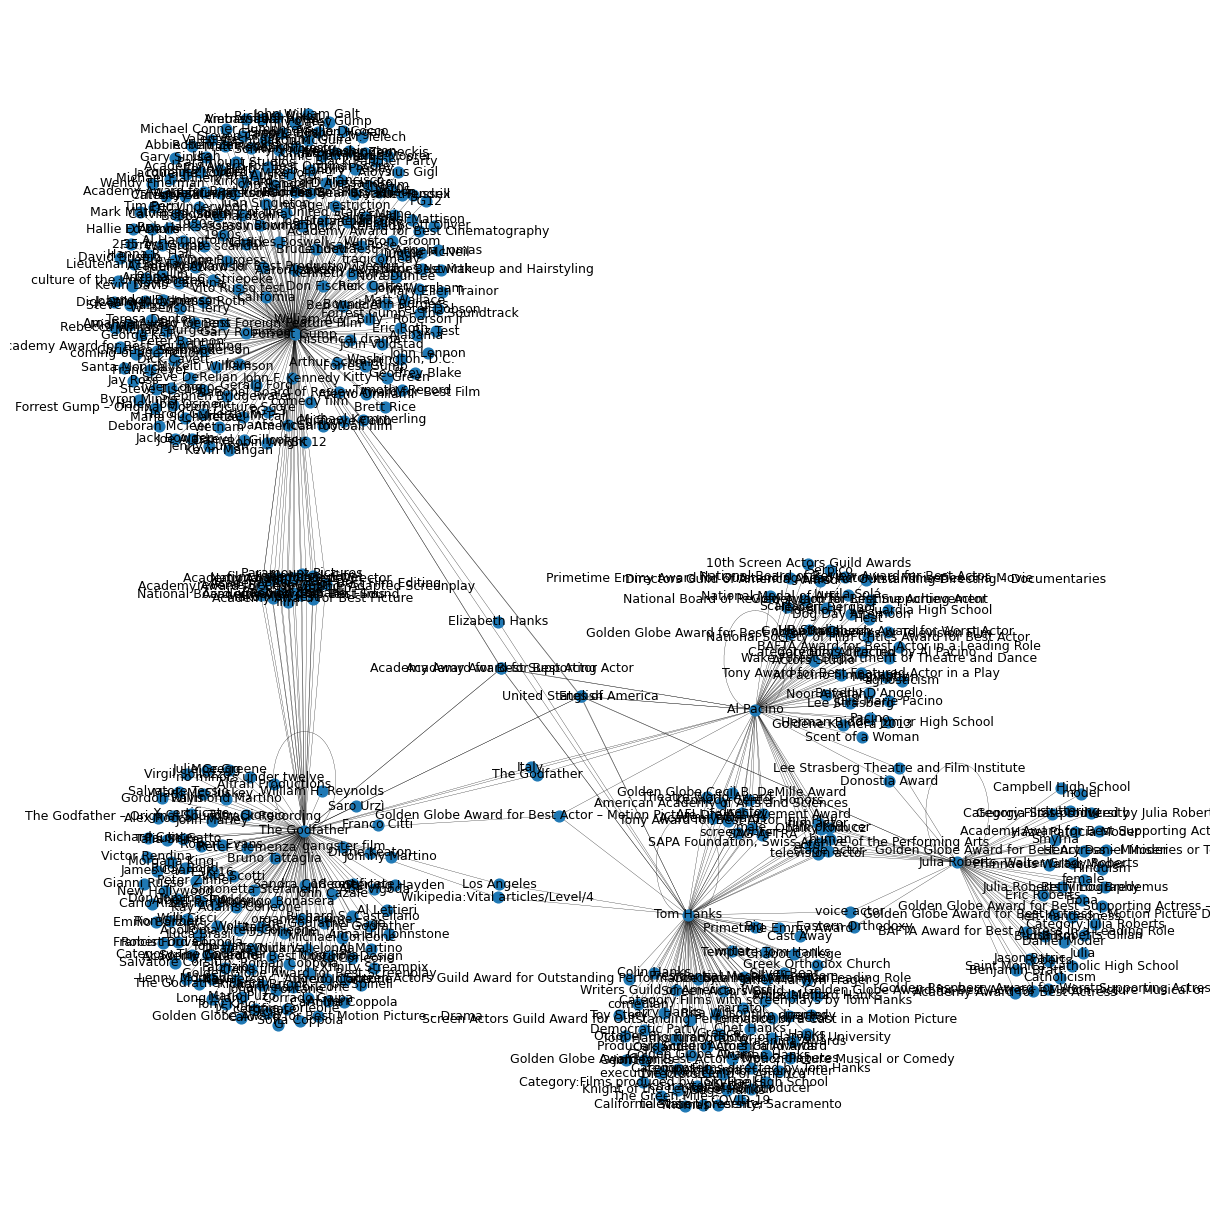

In [7]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## 2. Create a KG from the Movielens Dataset

In [8]:
# Obtain pairs of Movie Title - IDs from Movielens
df = movielens.load_pandas_df(
    MOVIELENS_DATA_SIZE,
    ("UserId", "ItemId", "Rating", "Timestamp"),
    title_col="Title",
    genres_col="Genres",
    year_col="Year",
)
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

100%|██████████| 4.81k/4.81k [00:01<00:00, 4.23kKB/s]


In [9]:
movies["Title"][0:5]

0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [10]:
# For notebook testing
if MOVIELENS_SAMPLE == True:
    movies = movies.head(MOVIELENS_SAMPLE_SIZE)

In [11]:
movies.shape

(50, 3)

In [12]:
%%time
names = [t + " film" for t in movies["Title"]]
result = search_wikidata(names, extras=movies[["Title", "ItemId"]].to_dict())
result.head()

CPU times: user 1.04 s, sys: 26 ms, total: 1.07 s
Wall time: 52.7 s


,name,original_entity,linked_entities,name_linked_entities,description,Title,ItemId
0,Kolya (1996) film,Q1141186,Q130232,drama film,1996 film by Jan Svěrák,Kolya (1996),242
1,Kolya (1996) film,Q1141186,Q157443,comedy film,1996 film by Jan Svěrák,Kolya (1996),242
2,Kolya (1996) film,Q1141186,Q100977416,Věra Uzelacová,1996 film by Jan Svěrák,Kolya (1996),242
3,Kolya (1996) film,Q1141186,Q104626218,Luboš Bíža,1996 film by Jan Svěrák,Kolya (1996),242
4,Kolya (1996) film,Q1141186,Q10819887,Andrei Chalimon,1996 film by Jan Svěrák,Kolya (1996),242


In [13]:
result["Title"].value_counts()

Aladdin (1992)                        259
Silence of the Lambs, The (1991)       99
Kolya (1996)                           96
Star Trek: First Contact (1996)        84
Sting, The (1973)                      82
Age of Innocence, The (1993)           81
L.A. Confidential (1997)               79
Fargo (1996)                           79
Last of the Mohicans, The (1992)       71
Chasing Amy (1997)                     70
Toy Story (1995)                       63
Remains of the Day, The (1993)         61
Twister (1996)                         58
Jackie Brown (1997)                    58
Sleepless in Seattle (1993)            57
Rear Window (1954)                     56
Sabrina (1954)                         54
Kiss the Girls (1997)                  54
Restoration (1995)                     52
Broken Arrow (1996)                    52
Just Cause (1995)                      51
Heavyweights (1994)                    47
Beautiful Thing (1996)                 44
Evil Dead II (1987)               

In [14]:
# result.to_csv("movielens_" + MOVIELENS_DATA_SIZE + '_wikidata.csv', index = False)

In [15]:
number_movies = len(result["Title"].unique())

In [17]:
# Record results for tests - ignore this cell
store_metadata("length_result", number_movies)